<a href="https://colab.research.google.com/github/nazwa48/PCVK-_GENAP_2024/blob/main/quis_2_pcvk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dan setup Kaggle
!pip install kaggle

from google.colab import files
files.upload()  # Upload file kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset
!kaggle datasets download -d rahmasleam/bird-speciees-dataset

# Ekstrak dataset
!unzip bird-speciees-dataset.zip -d /content/bird


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rahmasleam/bird-speciees-dataset
License(s): apache-2.0
 98% 15.0M/15.2M [00:00<00:00, 155MB/s]
100% 15.2M/15.2M [00:00<00:00, 155MB/s]
Archive:  bird-speciees-dataset.zip
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/001.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/002.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/003.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/004.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/005.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/006.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/007.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/008.jpg  
  inflating: /content/bird/Bird Speciees Dataset/AMERICAN GOLDFINCH/009.jpg  
  inflating: /content/bird/Bird Speciees Datase

In [6]:
import os
import numpy as np
import tensorflow as tf

def load_data(dataset_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))

    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.utils.img_to_array(img)
            images.append(img_array)
            labels.append(class_idx)

    return np.array(images), np.array(labels), class_names

# Path dataset
dataset_path = '/content/bird/Bird Speciees Dataset'

# Load data
images, labels, class_names = load_data(dataset_path)

# Normalisasi
images = images / 255.0


In [7]:
from sklearn.model_selection import train_test_split

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

# Base model (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze sebagian besar layer
for layer in base_model.layers[:-80]:
    layer.trainable = False

# Model akhir
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]


In [10]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.2458 - loss: 6.6681
Epoch 1: val_loss improved from inf to 4.77622, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2512 - loss: 6.6460 - val_accuracy: 0.9000 - val_loss: 4.7762 - learning_rate: 1.0000e-04
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.7424 - loss: 4.9744
Epoch 2: val_loss improved from 4.77622 to 4.44079, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 942ms/step - accuracy: 0.7437 - loss: 4.9712 - val_accuracy: 0.9385 - val_loss: 4.4408 - learning_rate: 1.0000e-04
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8613 - loss: 4.6760
Epoch 3: val_loss improved from 4.44079 to 4.30782, saving model to best_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 903ms/step - accuracy: 0.8619 - loss: 4.6720 - val_accuracy: 0.9615 - val_loss: 4.3078 - learning_rate: 1.0000e-04
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - ac

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.9962 - loss: 2.9744
Test Accuracy: 99.39%


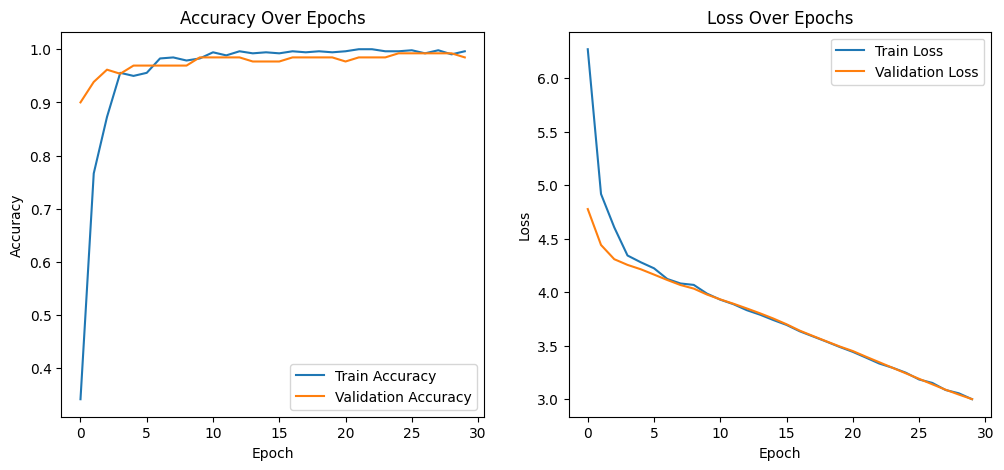

In [11]:
# Evaluasi
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step


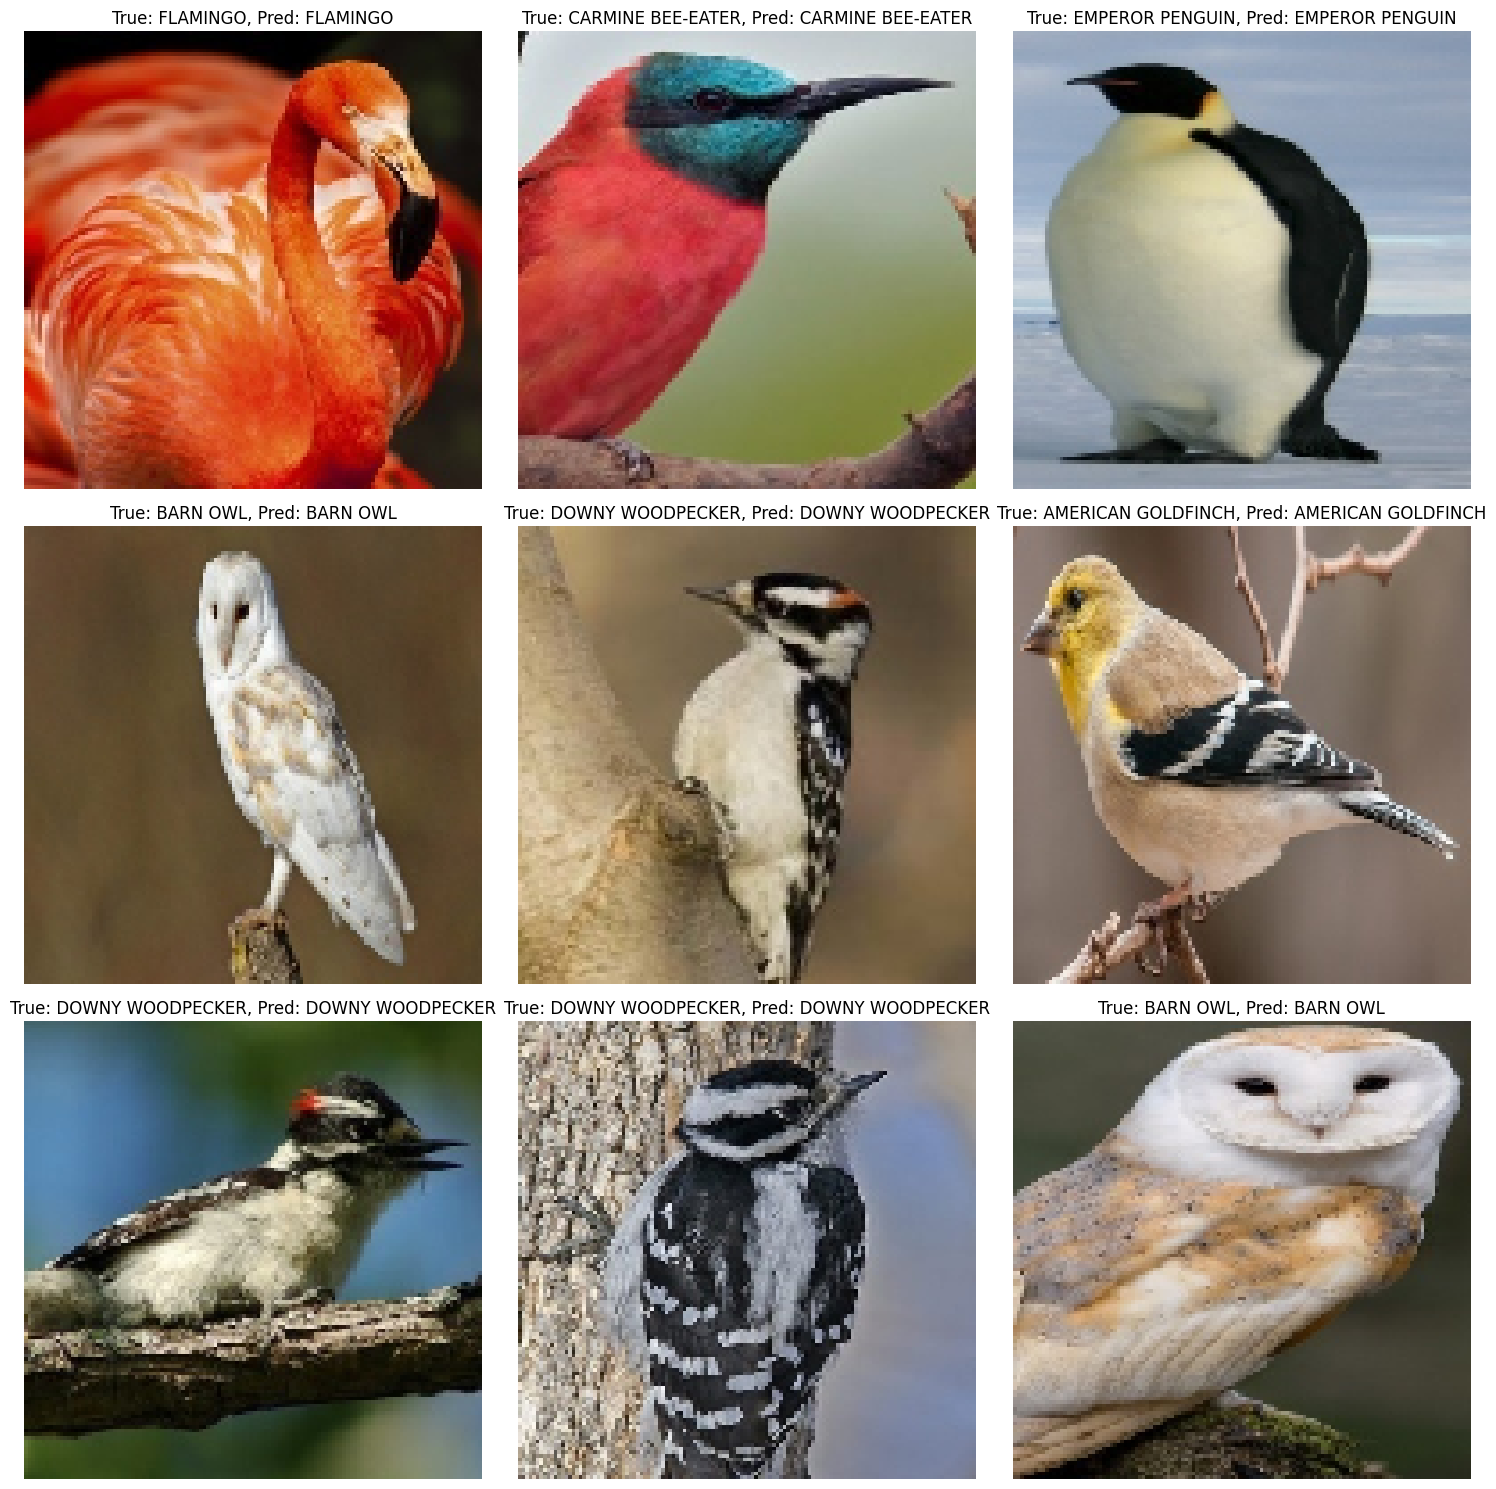

In [12]:
# Prediksi pada data test
predictions = model.predict(X_test)

# Tampilkan beberapa gambar dengan prediksi
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i])
    true_label = class_names[y_test[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step


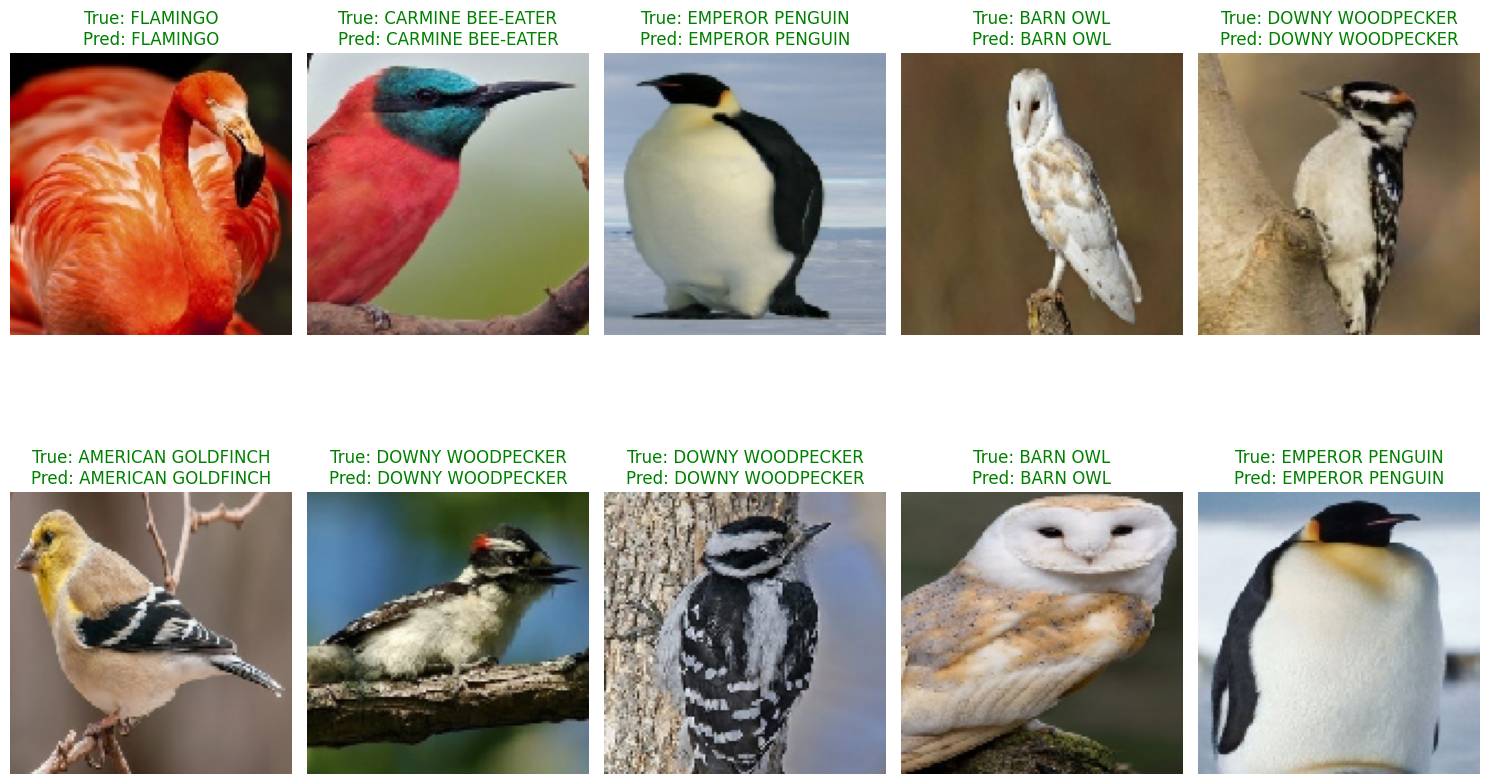

In [13]:
def plot_predictions(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Prediksi pada test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualisasi 10 gambar pertama
plot_predictions(X_test[:10], y_test[:10], predicted_labels[:10], class_names)
